In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 919 kB 24.4 MB/s 
     |████████████████████████████████| 119 kB 26.4 MB/s 
     |████████████████████████████████| 829 kB 37.3 MB/s 
     |████████████████████████████████| 282 kB 43.2 MB/s 
     |████████████████████████████████| 636 kB 54.2 MB/s 
     |████████████████████████████████| 1.3 MB 38.5 MB/s 
     |████████████████████████████████| 294 kB 55.6 MB/s 
     |████████████████████████████████| 142 kB 59.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=abd0c396b2528c1d186f2079649bb05dcd4b8241c3cc155fc463c13966560d56
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

In [2]:
import torch
from pytorch_lightning import LightningModule
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [115]:
class ODEDNNSolver(LightningModule):
    def __init__(
        self, ode, init_vars, init_coeffs, dt, solver="euler", outvar=None, **kwargs
    ):
        super().__init__(**kwargs)

        if ode.keys() != init_vars.keys():
            raise ValueError("Inconsistent keys in ode and init_vars")

        if solver == "euler":
            self.step_solver = self.euler_step
        elif solver == "rk4":
            self.step_solver = self.runge_kutta_4_step
        else:
            raise ValueError(f"Unrecognized solver {solver}")

        for name, value in init_coeffs.items():
            self.register_parameter(name, nn.Parameter(torch.tensor(value)))
        
        self.ode = ode
        self.var_names = ode.keys()
        self.init_vars = {
            name: torch.tensor(value, device=self.device)
            for name, value in init_vars.items()
        }
        self.coeffs = {name: param for name, param in self.named_parameters()}

        self.dnn = nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Tanh()
        )

        self.outvar = self.var_names if outvar is None else outvar
        self.dt = dt
        self.criterion = F.mse_loss

    def euler_step(self, prev_val):
        pred = {name: value.unsqueeze(0) for name, value in self.init_vars.items()}
        for var in self.var_names:
            pred[var] = prev_val[var] + self.ode[var](prev_val, self.coeffs, self.dnn) * self.dt
        return pred

    def runge_kutta_4_step(self, prev_val):
        pred = {name: value.unsqueeze(0) for name, value in self.init_vars.items()}

        k_1 = prev_val
        k_2 = {}
        k_3 = {}
        k_4 = {}

        for var in self.var_names:
            k_2[var] = (
                prev_val[var] + self.ode[var](prev_val, self.coeffs, self.dnn) * 0.5 * self.dt
            )

        for var in self.var_names:
            k_3[var] = prev_val[var] + self.ode[var](k_2, self.coeffs, self.dnn) * 0.5 * self.dt

        for var in self.var_names:
            k_4[var] = prev_val[var] + self.ode[var](k_3, self.coeffs, self.dnn) * self.dt

        for var in self.var_names:
            result = self.ode[var](k_1, self.coeffs, self.dnn) / 6
            result += self.ode[var](k_2, self.coeffs, self.dnn) / 3
            result += self.ode[var](k_3, self.coeffs, self.dnn) / 3
            result += self.ode[var](k_4, self.coeffs, self.dnn) / 6
            pred[var] = prev_val[var] + result * self.dt

        return pred

    def solver(self, nt):
        pred = {name: value.unsqueeze(0) for name, value in self.init_vars.items()}

        for n in range(nt - 1):
            # create dictionary containing values from previous time step
            prev_val = {var: pred[var][[n]] for var in self.var_names}
            new_val = self.step_solver(prev_val)
            for var in self.var_names:
                pred[var] = torch.cat([pred[var], new_val[var]])

        # reformat output to contain desired (observed) variables
        return torch.stack([pred[var] for var in self.outvar], dim=1)

    def forward(self, nt):
        return self.solver(nt)

    def get_coeffs(self):
        return {name: param.item() for name, param in self.named_parameters()}

    def fit(
        self,
        x,
        optim,
        optim_params=None,
        max_epochs=10,
        scheduler=None,
        scheduler_params=None,
    ):
        """Fits model to the given data by comparing the whole dataset
        Args:
            x (torch.Tensor): Original time series data
            optim (torch.optim): Optimizer
            optim_params: Optimizer parameters
            max_epochs (int): Number of training epochs
            scheduler (torch.optim.lr_scheduler): Learning rate scheduler
            scheduler_params: Learning rate scheduler parameters
        """
        dataset = TensorDataset(x)
        n = dataset.__len__()
        loader = DataLoader(dataset, batch_size=n)

        if optim_params is not None:
            optimizer = optim(self.parameters(), **optim_params)
        else:
            optimizer = optim(self.parameters())

        if scheduler is not None:
            if scheduler_params is not None:
                lr_scheduler = scheduler(optimizer, **scheduler_params)
            else:
                lr_scheduler = scheduler(optimizer)

        for epoch in range(max_epochs):
            for i, data in enumerate(loader, 0):
                self.zero_grad()
                loss = self._step(data, i, n)
                loss.backward(retain_graph=True)
                optimizer.step()
            if scheduler is not None:
                lr_scheduler.step()

            print("Epoch: " + str(epoch) + "\t Loss: " + str(loss))
            print(self.coeffs)
            # Testing to see that self.dnns changes
            print("DNN(1)", self.dnn(torch.Tensor([1.])))

    def fit_random_sample(
        self,
        x,
        optim,
        optim_params=None,
        max_epochs=10,
        batch_size=64,
        scheduler=None,
        scheduler_params=None,
    ):
        """Fits model to the given data by using random samples for each batch
        Args:
            x (torch.Tensor): Original time series data
            optim (torch.optim): Optimizer
            optim_params: Optimizer parameters
            max_epochs (int): Number of training epochs
            batch_size (int): Batch size for torch.utils.data.DataLoader
            scheduler (torch.optim.lr_scheduler): Learning rate scheduler
            scheduler_params: Learning rate scheduler parameters
        """
        dataset = TensorDataset(x)
        loader = DataLoader(dataset, batch_size=batch_size)

        if optim_params is not None:
            optimizer = optim(self.parameters(), **optim_params)
        else:
            optimizer = optim(self.parameters())

        if scheduler is not None:
            if scheduler_params is not None:
                lr_scheduler = scheduler(optimizer, **scheduler_params)
            else:
                lr_scheduler = scheduler(optimizer)

        for epoch in range(max_epochs):
            for i, data in enumerate(loader, 0):
                self.zero_grad()

                n = data[0].shape[0]

                if n < 3:
                    continue

                # Takes a random data point from "data"
                ri = torch.randint(low=0, high=n - 2, size=()).item()
                single_point = data[0][ri : ri + 1, :]
                init_point = {
                    var: single_point[0, i] for i, var in enumerate(self.var_names)
                }

                pred = {
                    name: value.unsqueeze(0) for name, value in self.init_vars.items()
                }

                pred = self.step_solver(init_point)

                predictions = torch.stack([pred[var] for var in self.outvar], dim=0)

                # Compare numerical integration data with next data point
                loss = self.criterion(predictions, data[0][ri + 1, :])

                loss.backward(retain_graph=True)
                optimizer.step()

            if scheduler is not None:
                lr_scheduler.step()

            print("Epoch: " + str(epoch) + "\t Loss: " + str(loss))
            print(self.coeffs)
            # Testing to see that self.dnns changes
            print("DNN(1)", self.dnn(torch.Tensor([1.])))

    def _step(self, batch, batch_idx, num_batches):
        (x,) = batch
        nt = x.shape[0]
        pred = self(nt)
        return self.criterion(pred, x)

In [116]:
# Duffing equation: Second order ODE system
dt = 0.01

def x_prime(prev_val, coeffs, dnns):
    return prev_val["x_"]

def x_prime_prime(prev_val, coeffs, dnns):
    return 0.8*torch.cos(0.5*prev_val["t"]) - coeffs["d"]*prev_val["x_"] - coeffs["a"]*prev_val["x"] - coeffs["b"]*prev_val["x"]*prev_val["x"]*prev_val["x"]

def t_prime(prev_val, coeffs, dnns):
    return 1

ode = {"x": x_prime, "x_": x_prime_prime, "t": t_prime}

# Initial conditions [0,0,0]
ode_init = {"x": 0, "x_": 0, "t": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "b": 0.5, "d": 0.2}

# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [117]:
ode_solver = ODEDNNSolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    solver="rk4"
)

result = ode_solver(1000)

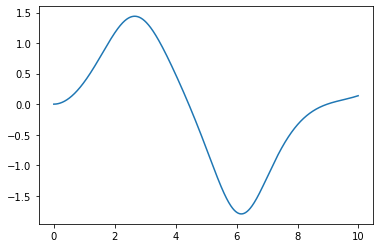

In [118]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,2], result_np[:,0])

plt.show()

# Euler's method for training

In [126]:
def x_prime_prime_train(prev_val, coeffs, dnns):
    return dnns(torch.Tensor([prev_val["t"]]))[0] - coeffs["d"]*prev_val["x_"] - coeffs["a"]*prev_val["x"] - coeffs["b"]*prev_val["x"]*prev_val["x"]*prev_val["x"]


In [129]:
ode_train_coeffs = {"a": 0., "b": 0., "d": 0.}
ode_train = {"x": x_prime, "x_": x_prime_prime_train, "t": t_prime}

ode_solver_train = ODEDNNSolver(
    ode=ode_train,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="rk4"
)

In [130]:
ode_solver_train.fit_random_sample(
    result,torch.optim.Adam,
    {"lr": 0.02},
    max_epochs=20,
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_params={"milestones": [10],"gamma": 0.2}
)

Epoch: 0	 Loss: tensor(2.0892e-05, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.0734, requires_grad=True), 'b': Parameter containing:
tensor(0.1057, requires_grad=True), 'd': Parameter containing:
tensor(-0.1188, requires_grad=True)}
DNN(1) tensor([-0.2622], grad_fn=<TanhBackward>)
Epoch: 1	 Loss: tensor(4.0188e-06, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.1766, requires_grad=True), 'b': Parameter containing:
tensor(0.2347, requires_grad=True), 'd': Parameter containing:
tensor(-0.1029, requires_grad=True)}
DNN(1) tensor([-0.0913], grad_fn=<TanhBackward>)
Epoch: 2	 Loss: tensor(1.6256e-06, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.2581, requires_grad=True), 'b': Parameter containing:
tensor(0.3456, requires_grad=True), 'd': Parameter containing:
tensor(-0.0545, requires_grad=True)}
DNN(1) tensor([0.3632], grad_fn=<TanhBackward>)
Epoch: 3	 Loss: tensor(2.4067e-08, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tenso

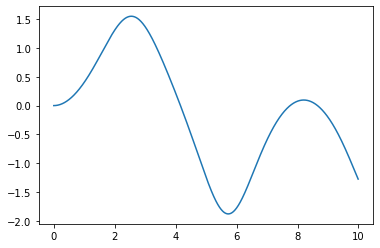

In [131]:
result = ode_solver_train(1000)

result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,2], result_np[:,0])

plt.show()